In [146]:
import os
from os.path import join as oj
import sys, time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

import statsmodels.tsa.api as smt
import traceback

font = {'size'   : 12}

plt.rc('font', **font)
cb = '#008fd5'
cr = '#fc4f30'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


*generate some arma data*

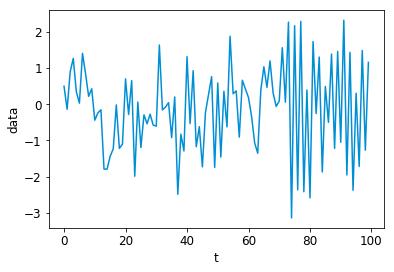

In [147]:
np.random.seed(42)
ar = [1, 0.75, -0.25] # first index is for zero lag
ma = [1, 0.75, 0.25] # first index is for zero lag

n = 100
sample = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, sigma=1)

plt.plot(sample, color=cb)
plt.xlabel('t')
plt.ylabel('data')
plt.show()

*fit and inspect an individual model*

In [172]:
def pred_all(s, mod):
    '''Doesn't return first time-step, so preds are one shorter than sample size.
    Note - this updates mod.fittedvalues
    '''
    return mod.predict(exog=s)


def fit(n=100, p=3, q=3, sigma=1, seed=1):    
    np.random.seed(seed)
    
    
    ar = [1, 0.75, -0.25] # first index is for zero lag
    ma = [1, 0.75, 0.25] # first index is for zero lag

    start_params = [0] * (len(ar) + len(ma) + 3) # this is very strange
    sample_train = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, sigma=sigma)
    mod = smt.ARMA(sample_train, order=(p, q)).fit(transparams=False, start_params=start_params, trend='nc')
    preds_train = deepcopy(mod.fittedvalues)

    sample_test = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, sigma=sigma)
    preds_test = pred_all(sample_test, mod)

    results = {
        'train_mse': metrics.mean_squared_error(sample_train, preds_train), 
        'test_mse': metrics.mean_squared_error(sample_test, preds_test), 
        'n': n,
        'p': p,
        'q': q,
        'sigma': sigma,
        'seed': seed
    }
    
    return results
    '''
    # plt.plot(s, color=cb, label='data1')
    plt.plot(sample, color=cb, label='data2')
    plt.plot(preds, label='preds')
    plt.plot(mod.fittedvalues, color=cr, linestyle='--', label='fitted')
    plt.xlabel('t')
    plt.xlim((0, 30))
    plt.legend()
    plt.show()
    '''
    
ns = [50, 100, 1000, 2000, 5000, 10000]
p = 3
q = 3
sigma = 0.1
seeds = range(9)

results_list = []
for n in tqdm(ns):
    for seed in seeds:
        results_list.append(fit(n, p, q, sigma, seed))
df = pd.DataFrame(results_list, index=range(len(results_list)))

In [175]:
ks = set(df.keys()) - {'seed', 'train_mse', 'test_mse'}
df2 = df.groupby(list(ks))

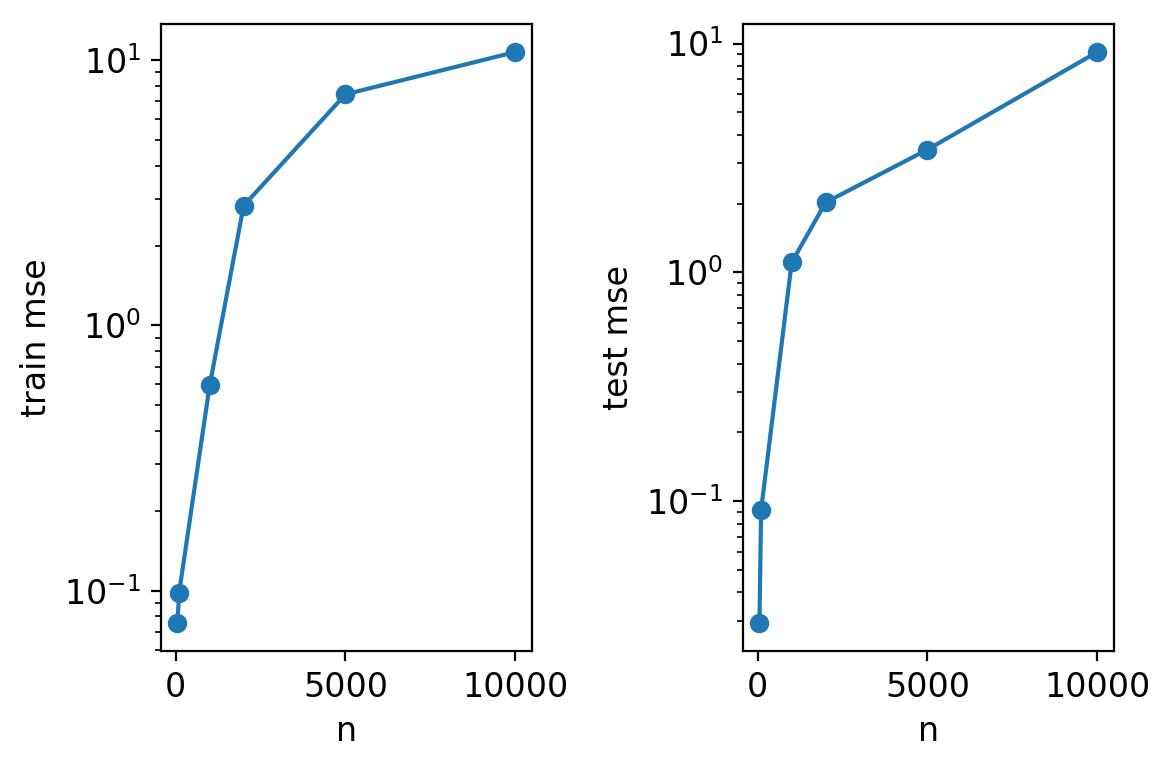

In [177]:
r = df2.mean()

plt.figure(dpi=200)
R, C = 1, 2
plt.subplot(R, C, 1)
plt.plot(ns, r.train_mse.values, 'o-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n')
plt.ylabel('train mse')

plt.subplot(R, C, 2)
plt.plot(ns, r.test_mse.values, 'o-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n')
plt.ylabel('test mse')
plt.tight_layout()

plt.show()

# analyze model selection

In [ ]:
# df_correct = pd.DataFrame.from_dict(correct_arr)
# results_all = {'df_correct': df_correct,
#                'sample_list': sample_list,
#                'results_list': results_list}
# pkl.dump(results_all, open('results_all.pkl', 'wb'))

In [5]:
results_all = pkl.load(open('results_all.pkl', 'rb'))

In [6]:
results_all.keys()

dict_keys(['df_correct', 'sample_list', 'results_list'])

In [ ]:
for i, r in enumerate(results_all['results_list']):
    print(i)
    for key in r:
        if 'min_order' in key:
            print('\t', key, r[key])

In [133]:
results

{'aic':             1           2           3           4
 1 -579.856746 -407.057775 -433.760027 -631.126512
 2 -346.147121 -355.196809 -356.840418 -509.561776
 3 -344.147121 -342.147121 -340.147121 -338.147121
 4 -342.147121 -340.147121 -338.147121 -336.147121,
 'bic':             1           2           3           4
 1 -569.436066 -394.031924 -418.129006 -612.890321
 2 -333.121270 -339.565788 -338.604227 -488.720415
 3 -328.516100 -323.910930 -319.305760 -314.700589
 4 -323.910930 -319.305760 -314.700589 -310.095419,
 'pls':           1         2         3         4
 1  0.000165  0.000904  0.000678  0.000093
 2  0.001663  0.001489  0.001435  0.000304
 3  0.001663  0.001663  0.001663  0.001663
 4  0.001663  0.001663  0.001663  0.001663,
 'aic_min_order': (1, 4),
 'bic_min_order': (1, 4),
 'pls_min_order': (1, 4),
 'pred': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0

In [129]:
# ar is row, max is col
results['bic']

0    0
1    0
Name: bic, dtype: int64